### Autores:
- Óscar Muñoz Hidalgo
- Juan José Quesada Acosta

### Paquetes a instalar

In [ ]:
pip install scikit-learn seaborn

TAREA: Captura una o varias imágenes con monedas no solapadas. Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de monedas y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.

In [2]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt

Radio en píxeles: 94.1086654663086
Relación mm/píxel: 0.12352741314944916
A contar dinero!
La relación mm/píxel es: 0.12352741314944916
El dinero total es: 3.88 euros
Conteo de monedas:
1 monedas de 0.01 euros
1 monedas de 0.02 euros
1 monedas de 0.05 euros
1 monedas de 0.1 euros
1 monedas de 0.2 euros
1 monedas de 0.5 euros
1 monedas de 1.0 euros
1 monedas de 2.0 euros


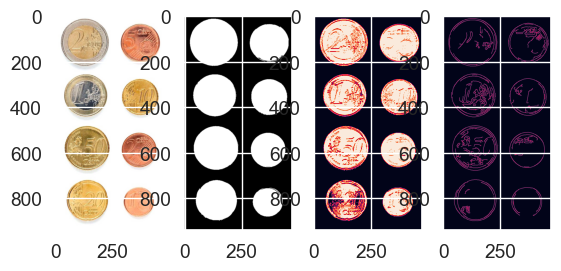

In [48]:
img = cv2.imread('Monedas.jpg')
# Probar con SixScattered y UnasCuantas
if img.shape[1] > 800:
    factor_reduccion = img.shape[1]//500
    img = cv2.resize(img, (img.shape[1]//factor_reduccion,img.shape[0]//factor_reduccion))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

umbral = 200

th1,img_th1 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)
th2,img_th2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

img_median_blur = cv2.medianBlur(img_gris, 7)
img_gaussian_blur = cv2.GaussianBlur(img_gris, (9, 9), 3)

canny_output = cv2.Canny(img_gaussian_blur, 0, 85)

diff = cv2.subtract(img_th2, canny_output)

contornos2, hierarchy2 = cv2.findContours(diff, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)
#cv2.drawContours(img, contornos2, -1, (0,255,0), 3)

img_blur = cv2.medianBlur(img_gris, 7)

img_cont = np.zeros(img_rgb.shape, dtype=np.uint8)
#Recorre los contornos externos
for c in contornos2:
    #Área del contorno
    area = cv2.contourArea(c)
    #Área mínima (útil filtrar en ocasiones)
    if area > 10:
        #Perímetro del contorno
        perimetro = cv2.arcLength(c,True)
        #Contenedor alineado con ejes de la imagen
        x,y,w,h = cv2.boundingRect(c)
        #Mínimo contenedor ajustado para el contorno
        (cx,cy),radio = cv2.minEnclosingCircle(c)
        
        #cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)
        #print(f'Area: {area}, Perímetro: {perimetro}, Circularidad: {circularidad}, Relación perimetro circulo: {relacion_perimetro_circulo}')
            

        circularidad = 4*np.pi*area/(perimetro*perimetro)
        relacion_perimetro_circulo = perimetro/(2*np.pi*radio)

        cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)

        if  0.5 < circularidad < 1.1 and 1 < relacion_perimetro_circulo < 1.5:
            cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)
            #print(f'Area: {area}, Perímetro: {perimetro}, Circularidad: {circularidad}, Relación perimetro circulo: {relacion_perimetro_circulo}')


plt.subplot(1, 4, 1)
plt.imshow(img_rgb)

plt.subplot(1, 4, 2)
plt.imshow(img_cont)    

plt.subplot(1, 4, 3)
plt.imshow(img_th2)

plt.subplot(1, 4, 4)
plt.imshow(canny_output)

contornos_radi = [(c, cv2.minEnclosingCircle(c)[1]) for c in contornos2]

relacion_mm_por_pixel = 0

# Diccionario con diámetros de las monedas y su valor
monedas = {
    16.25: 0.01,  # 1 céntimo
    18.75: 0.02,  # 2 céntimos
    21.25: 0.05,  # 5 céntimos
    19.75: 0.10,  # 10 céntimos
    22.25: 0.20,  # 20 céntimos
    24.25: 0.50,  # 50 céntimos
    23.25: 1.00,  # 1 euro
    25.75: 2.00   # 2 euros
}



def isCoin(x, y, img):
    return (0 != np.sum(img[y,x]))

def countMoney():
    global relacion_mm_por_pixel
    print('La relación mm/píxel es:', relacion_mm_por_pixel)
    # Error permitido en los diámetros (en mm)
    error = 0.5
    dinero_total = 0

    conteo = {
        0.01: 0,  # 1 céntimo
        0.02: 0,  # 2 céntimos
        0.05: 0,  # 5 céntimos
        0.10: 0,  # 10 céntimos
        0.20: 0,  # 20 céntimos
        0.50: 0,  # 50 céntimos
        1.00: 0,  # 1 euro
        2.00: 0   # 2 euros
    }

    for c, radio in contornos_radi:
        diametro_modeda_pixeles = radio * 2
        #print('Dinero total:', dinero_total)
        #print(f'Este contorno tiene un diámetro en mm estimado: {diametro_modeda_pixeles * relacion_mm_por_pixel} mm')
        for diametro_real, valor in monedas.items():
            if (diametro_real - error) < diametro_modeda_pixeles * relacion_mm_por_pixel < (diametro_real + error):
                dinero_total += valor
                conteo[valor] += 1
                #print(f'Esta moneda es de {valor} euros')
                break

    print(f'El dinero total es: {round(dinero_total, 2)} euros')
    print('Conteo de monedas:')
    for valor, cantidad in conteo.items():
        print(f'{cantidad} monedas de {valor} euros')

def on_mouse(event, x, y, flags, userdata):
    global relacion_mm_por_pixel
    if event == cv2.EVENT_LBUTTONDOWN and isCoin(x,y, img_cont):
        #print(f'Mouse position: ({x}, {y})')
        # Buscar si el clic está dentro de algún contorno
        for c, radio in contornos_radi:
            dist = cv2.pointPolygonTest(c, (x, y), False)
            if dist >= 0:  # Si está dentro del contorno
                #print(f'Mouse position: ({x}, {y})')
                print(f'Radio en píxeles: {radio}')
                
                diametro_modeda_pixeles = radio * 2
                # Radio real de la moneda de 1€ en mm
                diametro_moneda_real = 23.25
                
                # Relación en mm/píxel
                relacion_mm_por_pixel = diametro_moneda_real / diametro_modeda_pixeles
                
                print(f'Relación mm/píxel: {relacion_mm_por_pixel}')
                print("A contar dinero!")
                countMoney()
                break

windowName = "amor"

cv2.namedWindow(windowName)

cv2.setMouseCallback(windowName, on_mouse)

cv2.imshow(windowName,img_rgb)
while cv2.waitKey(20) != 27:
    dummy = 0    
     # Se detiene hasta pulsar tecla (>0 milisegundos)

cv2.destroyAllWindows() # Destruye todas las ventanas





TAREA: Las tres imágenes cargadas en la celda inicial, han sido extraidas de las imágenes de mayor tamaño presentes en la carpeta. La tarea consiste en extraer características (geométricas y/o visuales) e identificar patrones que permitan distinguir las partículas de cada una de las tres clases, evaluando los aciertos y fallos con las imágenes completas considerando las métricas mostradas y la matriz de confusión. La matriz de confusión, muestra para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente por cada una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

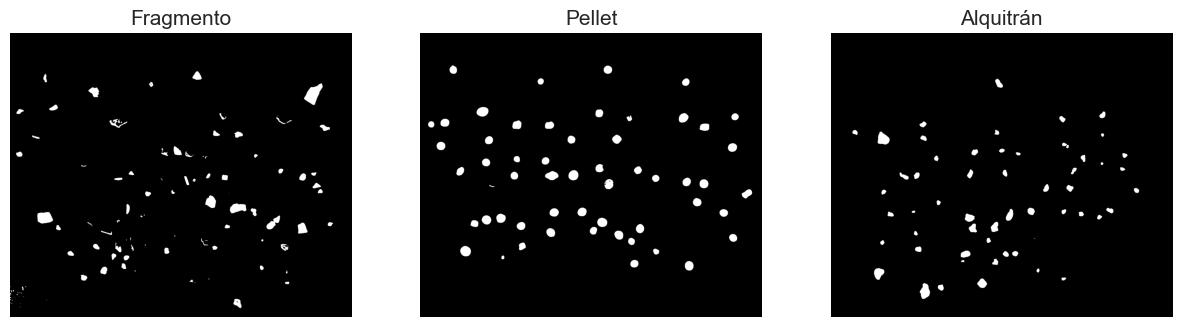

Fragmentos: 73, Pellets: 9, Alquitrán: 0
Fragmentos: 2, Pellets: 46, Alquitrán: 0
Fragmentos: 4, Pellets: 3, Alquitrán: 48


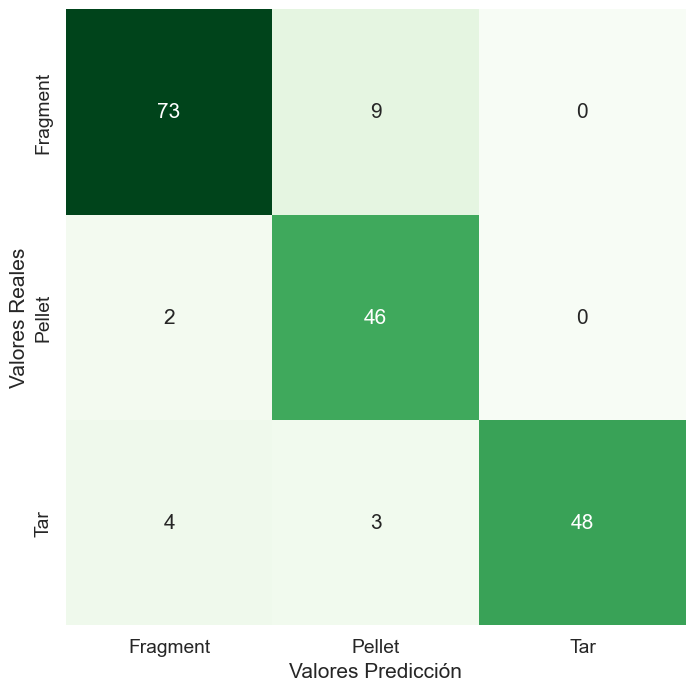

In [41]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Se cargan las tres imágenes: fragmentos, pellets y alquitrán
frag = cv2.imread('fragment-03-olympus-10-01-2020.JPG')
pellet = cv2.imread('pellet-03-olympus-10-01-2020.JPG')
tar = cv2.imread('tar-03-olympus-10-01-2020.JPG')

# Recortar las imágenes para evitar las sombras que aparecen
left_limit, right_limit = 750, 4000
upper_limit, lower_limit = 0, 2700

frag_r = frag[upper_limit:lower_limit, left_limit:right_limit]
pellet_r = pellet[upper_limit:lower_limit, left_limit:right_limit]
tar_r = tar[upper_limit:lower_limit, left_limit:right_limit]

# Conversión de las imágenes a escala de grises
frag_gris = cv2.cvtColor(frag_r, cv2.COLOR_BGR2GRAY)
pellet_gris = cv2.cvtColor(pellet_r, cv2.COLOR_BGR2GRAY)
tar_gris = cv2.cvtColor(tar_r, cv2.COLOR_BGR2GRAY)


# Filtrado de las imágenes
frag_filtrado = cv2.GaussianBlur(frag_gris, (15, 15), 0)
pellet_filtrado = cv2.GaussianBlur(pellet_gris, (15, 15), 0)
'''
Este filtrado no ayuda a mejorar el reconocimiento
alqui_filtrado = cv2.GaussianBlur(alqui_gris, (15, 15), 0)
'''
# Umbralizado fragmentos y pellet con umbral fijo
_,frag_umbral = cv2.threshold(frag_filtrado,115,255,cv2.THRESH_BINARY_INV)
_,pel_umbral = cv2.threshold(pellet_filtrado,100,255,cv2.THRESH_BINARY_INV)

# Umbralizado con método de Otsu (el que mejor se ajusta a la imagen)
_,tar_umbral = cv2.threshold(tar_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Mostrar las imágenes umbralizadas
plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.title('Fragmento')
plt.axis("off")
plt.imshow(frag_umbral,cmap='gray') 

plt.subplot(132)
plt.title('Pellet')
plt.axis("off")
plt.imshow(pel_umbral,cmap='gray') 

plt.subplot(133)
plt.title('Alquitrán')
plt.axis("off")
plt.imshow(tar_umbral,cmap='gray') 

plt.show()


# Clasifición de los fragmentos, pellets y alquitrán

def clasificarElementos(imagen, color):
    contornos, _ = cv2.findContours(imagen, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    fragments, pellets, tar = 0, 0, 0

    for contorno in contornos:
        area = cv2.contourArea(contorno)
        perimetro = cv2.arcLength(contorno, True)
        x, y, w, h = cv2.boundingRect(contorno)
        (cx, cy), radio = cv2.minEnclosingCircle(contorno)

        compacidad = (perimetro ** 2) / area if area > 0 else 0

        eje_mayor, eje_menor, relacion_ejes_elipse, excentricidad = 0, 0, 0, 0
        if contorno.shape[0] > 5:
            elipse = cv2.fitEllipse(contorno)
            eje_mayor = elipse[1][1]
            eje_menor = elipse[1][0]
            relacion_ejes_elipse = eje_menor / eje_mayor 

        relacion_aspecto = w / h
        relacion_area_contenedor = area / (w * h)

        epsilon = 0.02 * cv2.arcLength(contorno, True)
        lados_aproximados = cv2.approxPolyDP(contorno, epsilon, True)

        # Calcular la intensidad promedio dentro del contorno
        mask = np.zeros(color.shape, dtype=np.uint8)                            # Crear una máscara vacía
        cv2.drawContours(mask, [contorno], -1, (255), thickness=cv2.FILLED)     # Dibujar el contorno en la máscara
        mean_color = cv2.mean(color, mask=mask)                                 # Obtener el valor medio de intensidad
        mean_value = mean_color[0]

        if 13 < compacidad < 15 and np.isclose(relacion_aspecto, 1.0, rtol=1):
            pellets += 1
        elif mean_value < 55 and compacidad > 15 and 0.55 < relacion_area_contenedor < 0.75:
            tar += 1

        elif relacion_area_contenedor < 0.65 and len(lados_aproximados) < 9 and relacion_ejes_elipse < 0.78:
            fragments += 1
        else:
            continue

    print(f'Fragmentos: {fragments}, Pellets: {pellets}, Alquitrán: {tar}')

    return [fragments, pellets, tar]

total_frag, total_pellet, total_tar = clasificarElementos(frag_umbral, frag_gris), clasificarElementos(pel_umbral, pellet_gris), clasificarElementos(tar_umbral, alqui_gris)

matriz_confusion = np.array([total_frag, total_pellet, total_tar])

plt.figure(figsize=(8, 8))
sns.set(font_scale=1.25)
sns.heatmap(matriz_confusion, annot=True, fmt='d', cbar=False, cmap='Greens', 
            xticklabels=['Fragment', 'Pellet', 'Tar'], 
            yticklabels=['Fragment', 'Pellet', 'Tar'])
plt.xlabel("Valores Predicción")
plt.ylabel("Valores Reales")
plt.show()
